In [34]:
# ====================================
# 1) IMPORTING LIBRARIES
# ====================================

import os
import matplotlib
import torch
import datetime
import csv
import cv2

import gymnasium as gym
import gymnasium.wrappers as gym_wrap
import matplotlib.pyplot as plt
import numpy as np

from gymnasium.spaces import Box
from tensordict import TensorDict
from torch import nn
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [35]:
# ====================================
# 2) GYMNASIUM WRAPPER FUNCTIONS
# ====================================

def create_skip_frame_wrapper(env, skip=4):
    """Skip frames wrapper to reduce computational load"""
    class SkipFrame(gym.Wrapper):
        def __init__(self, env, skip):
            super().__init__(env)
            self._skip = skip

        def step(self, action):
            total_reward = 0.0
            for _ in range(self._skip):
                state, reward, terminated, truncated, info = self.env.step(action)
                total_reward += reward
                if terminated:
                    break
            return state, total_reward, terminated, truncated, info
    
    return SkipFrame(env, skip)

def create_grayscale_wrapper(env):
    """Convert RGB observations to grayscale"""
    class GrayScaleObservation(gym.ObservationWrapper):
        def __init__(self, env):
            super().__init__(env)
            obs_space = env.observation_space
            h, w = obs_space.shape[:2]
            self.observation_space = gym.spaces.Box(
                low=0, high=255, shape=(h, w), dtype=np.uint8
            )

        def observation(self, obs):
            return cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    
    return GrayScaleObservation(env)

def create_resize_wrapper(env, shape=84):
    """Resize observations to specified shape"""
    class ResizeObservation(gym.ObservationWrapper):
        def __init__(self, env, shape):
            super().__init__(env)
            self.shape = (shape, shape)
            self.observation_space = gym.spaces.Box(
                low=0, high=255, shape=(shape, shape), dtype=np.uint8
            )

        def observation(self, obs):
            return cv2.resize(obs, self.shape, interpolation=cv2.INTER_AREA)
    
    return ResizeObservation(env, shape)

def create_frame_stack_wrapper(env, num_stack=4):
    """Stack multiple frames to provide temporal information"""
    class FrameStack(gym.Wrapper):
        def __init__(self, env, num_stack):
            super().__init__(env)
            self.num_stack = num_stack
            self.frames = []
            obs_shape = env.observation_space.shape
            self.observation_space = gym.spaces.Box(
                low=0,
                high=255,
                shape=(num_stack, *obs_shape),
                dtype=np.uint8
            )

        def reset(self, **kwargs):
            obs, info = self.env.reset(**kwargs)
            self.frames = [obs for _ in range(self.num_stack)]
            return self._get_observation(), info

        def step(self, action):
            obs, reward, terminated, truncated, info = self.env.step(action)
            self.frames.pop(0)
            self.frames.append(obs)
            return self._get_observation(), reward, terminated, truncated, info

        def _get_observation(self):
            return np.stack(self.frames, axis=0)
    
    return FrameStack(env, num_stack)
    

In [36]:
# ====================================
# 3) DQN NEURAL NETWORK FUNCTIONS
# ====================================

def create_dqn_network(in_dim, out_dim):
    """Create DQN neural network"""
    channel_n, height, width = in_dim
    
    if height != 84 or width != 84:
        raise ValueError(f"DQN model requires input of a (84, 84)-shape. Input of a ({height, width})-shape was passed.")
    
    net = nn.Sequential(
        nn.Conv2d(in_channels=channel_n, out_channels=16,
                  kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32,
                  kernel_size=4, stride=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(2592, 256),
        nn.ReLU(),
        nn.Linear(256, out_dim),
    )
    return net

In [44]:
# ====================================
# 4) MODEL LOADING FUNCTIONS
# ====================================

def load_model_for_evaluation(model_path, state_shape, action_n):
    """Load a trained model for evaluation with improved state dict handling"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Create network
    network = create_dqn_network(state_shape, action_n).float().to(device)
    
    # Load saved model
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    loaded_model = torch.load(model_path, map_location=device)
    
    # Extract the state dict
    state_dict = None
    if 'upd_model_state_dict' in loaded_model:
        state_dict = loaded_model['upd_model_state_dict']
    elif 'model_state_dict' in loaded_model:
        state_dict = loaded_model['model_state_dict']
    else:
        # If it's just the state dict directly
        state_dict = loaded_model
    
    # Handle the case where keys have "net." prefix
    if any(key.startswith('net.') for key in state_dict.keys()):
        # Remove "net." prefix from all keys
        new_state_dict = {}
        for key, value in state_dict.items():
            if key.startswith('net.'):
                new_key = key[4:]  # Remove "net." prefix
                new_state_dict[new_key] = value
            else:
                new_state_dict[key] = value
        state_dict = new_state_dict
    
    # Load the corrected state dict
    try:
        network.load_state_dict(state_dict)
        print(f"Successfully loaded model parameters")
    except Exception as e:
        print(f"Error loading state dict: {e}")
        print("Available keys in state dict:", list(state_dict.keys()))
        print("Expected keys in network:", list(network.state_dict().keys()))
        raise
    
    # Set to evaluation mode
    network.eval()
    
    return network, device

def take_greedy_action(network, state, device):
    """Take greedy action (no exploration) for evaluation"""
    with torch.no_grad():
        state_tensor = torch.tensor(
            state, dtype=torch.float32, device=device
        ).unsqueeze(0)
        action_values = network(state_tensor)
        action_idx = torch.argmax(action_values, axis=1).item()
    return action_idx

In [38]:
# ====================================
# 5) ENVIRONMENT SETUP FUNCTION
# ====================================

def setup_evaluation_environment(env_name="CarRacing-v3", skip_frames=4, resize_shape=84, frame_stack=4):
    """Setup and wrap the environment for evaluation"""
    env = gym.make(env_name, continuous=False)
    env = create_skip_frame_wrapper(env, skip=skip_frames)
    env = create_grayscale_wrapper(env)
    env = create_resize_wrapper(env, shape=resize_shape)
    env = create_frame_stack_wrapper(env, num_stack=frame_stack)
    return env

In [41]:
# ====================================
# 6) EVALUATION FUNCTIONS
# ====================================

def evaluate_single_episode(env, network, device, seed=None):
    """Evaluate a single episode and return the score"""
    if seed is not None:
        state, info = env.reset(seed=seed)
    else:
        state, info = env.reset()
    
    done = False
    score = 0
    steps = 0
    
    while not done:
        action = take_greedy_action(network, state, device)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        score += reward
        steps += 1
    
    return score, terminated, steps

def evaluate_model(model_name, model_path, episodes=100, verbose=True):
    """
    Evaluate a trained DQN model
    
    Args:
        model_name (str): Name of the model for reporting
        model_path (str): Path to the saved model file
        episodes (int): Number of episodes to evaluate
        verbose (bool): Whether to print progress during evaluation
    
    Returns:
        dict: Dictionary containing evaluation statistics
    """
    
    # Setup environment
    env = setup_evaluation_environment()
    state, info = env.reset()
    action_n = env.action_space.n
    
    # Load model
    try:
        network, device = load_model_for_evaluation(model_path, state.shape, action_n)
        if verbose:
            print(f"Successfully loaded model: {model_name}")
            print(f"Model path: {model_path}")
            print(f"Device: {device}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return None
    
    # Run evaluation episodes
    scores = []
    completed = 0
    total_steps = 0
    if verbose:
        print(f"\nStarting evaluation for {episodes} episodes...")
    
    for episode in range(episodes):
        score, terminated, steps = evaluate_single_episode(env, network, device, seed=episode)
        
        if terminated:
            completed += 1
        
        scores.append(score)
        total_steps += steps
        
        if verbose and (episode + 1) % 10 == 0:
            print(f"[{model_name}] Episode {episode + 1}: Score = {score:.2f}, Steps = {steps}")
    
    env.close()
    
    # Compute statistics
    scores_np = np.array(scores)
    completion_rate = (completed / episodes) * 100
    
    summary = {
        "Model": model_name,
        "Episodes": episodes,
        "Completed episodes": f"{completion_rate:.1f}%",
        "Completed count": completed,
        "Total steps": total_steps,
        "Average steps per episode": round(total_steps / episodes, 1),
        "Minimum score": round(scores_np.min(), 2),
        "Maximum score": round(scores_np.max(), 2),
        "Median score": round(np.median(scores_np), 2),
        "Mean score": round(scores_np.mean(), 2),
        "Standard deviation": round(scores_np.std(), 2),
        "Scores": scores  # Include raw scores for further analysis
    }

    if verbose:
        print(f"\n=== Evaluation Results for {model_name} ===")
        for key, value in summary.items():
            if key != "Scores":  # Don't print the raw scores list
                print(f"{key}: {value}")
    
    return summary

def compare_models(model_configs, episodes=100):
    """
    Compare multiple models
    
    Args:
        model_configs (list): List of tuples (model_name, model_path)
        episodes (int): Number of episodes to evaluate each model
    
    Returns:
        list: List of evaluation summaries for each model
    """
    results = []
    
    print(f"Comparing {len(model_configs)} models over {episodes} episodes each...\n")
    
    for i, (model_name, model_path) in enumerate(model_configs):
        print(f"Evaluating model {i+1}/{len(model_configs)}: {model_name}")
        result = evaluate_model(model_name, model_path, episodes, verbose=True)
        if result:
            results.append(result)
        print("-" * 50)
    
    # Print comparison summary
    if results:
        print("\n=== COMPARISON SUMMARY ===")
        print(f"{'Model':<20} {'Mean Score':<12} {'Completion':<12} {'Std Dev':<10}")
        print("-" * 60)
        for result in results:
            print(f"{result['Model']:<20} {result['Mean score']:<12} "
                  f"{result['Completed episodes']:<12} {result['Standard deviation']:<10}")
    
    return results   

def save_evaluation_results(results, filename="evaluation_results.csv"):
    """Save evaluation results to CSV file"""
    if not results:
        print("No results to save.")
        return
    
    # Prepare data for CSV
    fieldnames = ["Model", "Episodes", "Completed episodes", "Completed count", 
                 "Total steps", "Average steps per episode", "Minimum score", 
                 "Maximum score", "Median score", "Mean score", "Standard deviation"]
    
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        for result in results:
            # Create a copy without the raw scores for CSV
            csv_result = {k: v for k, v in result.items() if k != "Scores"}
            writer.writerow(csv_result)
    
    print(f"Results saved to {filename}")

In [47]:
# ====================================
# 7) MAIN EXECUTION EXAMPLES
# ====================================

dqn_summary = evaluate_model("DQN", "training/saved_models/DQN_740863.pt", episodes=100)       
ddqn_summary = evaluate_model("DDQN", "training/saved_models/DDQN_743266.pt", episodes=100)     

Successfully loaded model parameters
Successfully loaded model: DQN
Model path: training/saved_models/DQN_740863.pt
Device: cpu

Starting evaluation for 100 episodes...
[DQN] Episode 10: Score = 919.00, Steps = 203
[DQN] Episode 20: Score = 831.43, Steps = 250
[DQN] Episode 30: Score = 915.50, Steps = 212
[DQN] Episode 40: Score = 872.89, Steps = 250
[DQN] Episode 50: Score = 848.01, Steps = 250
[DQN] Episode 60: Score = 915.50, Steps = 212
[DQN] Episode 70: Score = 876.43, Steps = 250
[DQN] Episode 80: Score = 904.40, Steps = 239
[DQN] Episode 90: Score = 873.51, Steps = 250
[DQN] Episode 100: Score = 869.81, Steps = 250

=== Evaluation Results for DQN ===
Model: DQN
Episodes: 100
Completed episodes: 38.0%
Completed count: 38
Total steps: 23497
Average steps per episode: 235.0
Minimum score: 680.56
Maximum score: 928.0
Median score: 892.8
Mean score: 888.5
Standard deviation: 34.9
Successfully loaded model parameters
Successfully loaded model: DDQN
Model path: training/saved_models/DD

## Compare both models

In [50]:
import pandas as pd

df_summary = pd.DataFrame([dqn_summary, ddqn_summary])
df_summary = df_summary[
    ["Model", "Completed episodes", "Minimum score", "Maximum score", "Mean score", "Standard deviation"]
]

df_summary

,Model,Completed episodes,Minimum score,Maximum score,Mean score,Standard deviation
0,DQN,38.0%,680.56,928.0,888.50,34.90
1,DDQN,27.0%,465.50,928.4,863.19,88.32


In [51]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_training_progress(csv_path, window_size=50):
    # Load CSV
    df = pd.read_csv(csv_path)

    # Extract episode times (skip label "time")
    times = df.iloc[0, 1:].values
    time_fmt = "%H:%M:%S"
    start_time = datetime.strptime(times[0], time_fmt)
    end_time = datetime.strptime(times[-1], time_fmt)
    if end_time < start_time:  # handle wrap-around midnight
        end_time = end_time.replace(day=start_time.day + 1)
    duration = end_time - start_time

    # Extract reward values (skip label "reward")
    rewards_str = df.iloc[1, 1:].values
    rewards = pd.to_numeric(rewards_str, errors='coerce')
    rewards_series = pd.Series(rewards)

    # Compute sliding window average
    rolling_avg = rewards_series.rolling(window=window_size, min_periods=1).mean()

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(rewards_series, label="Episode Reward", alpha=0.4)
    plt.plot(rolling_avg, label=f"Moving Average (window={window_size})", linewidth=2, color="orange")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(f"Training Progress\nTotal Training Time: {duration}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

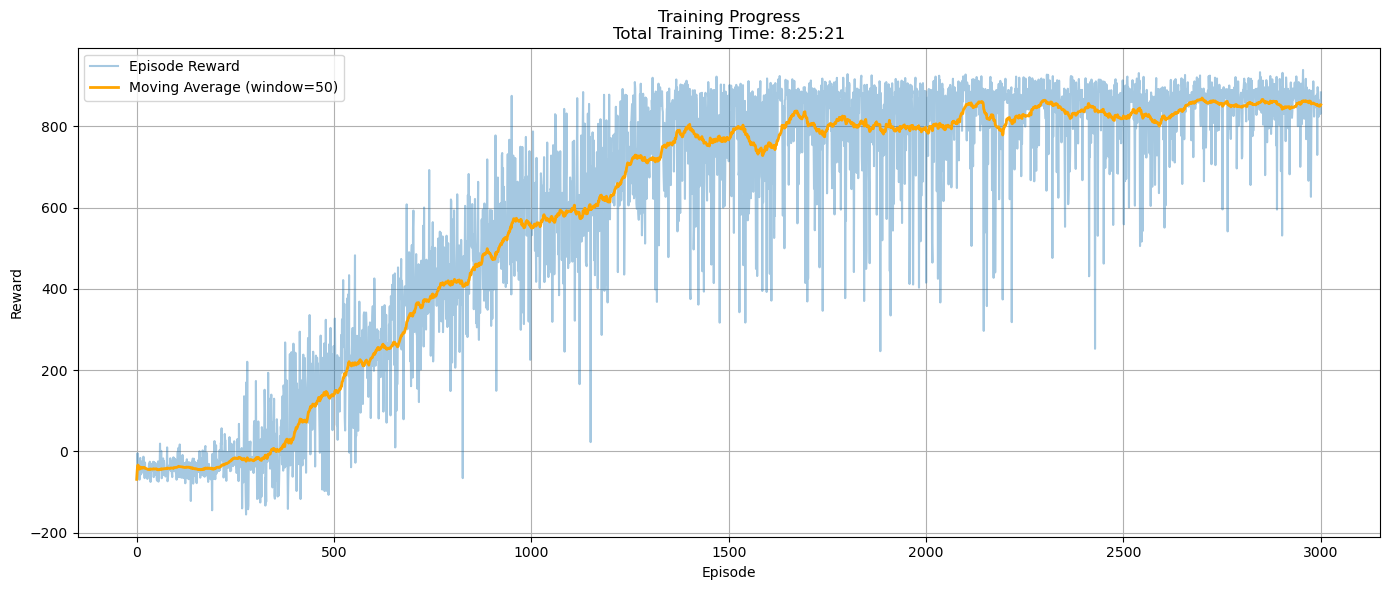

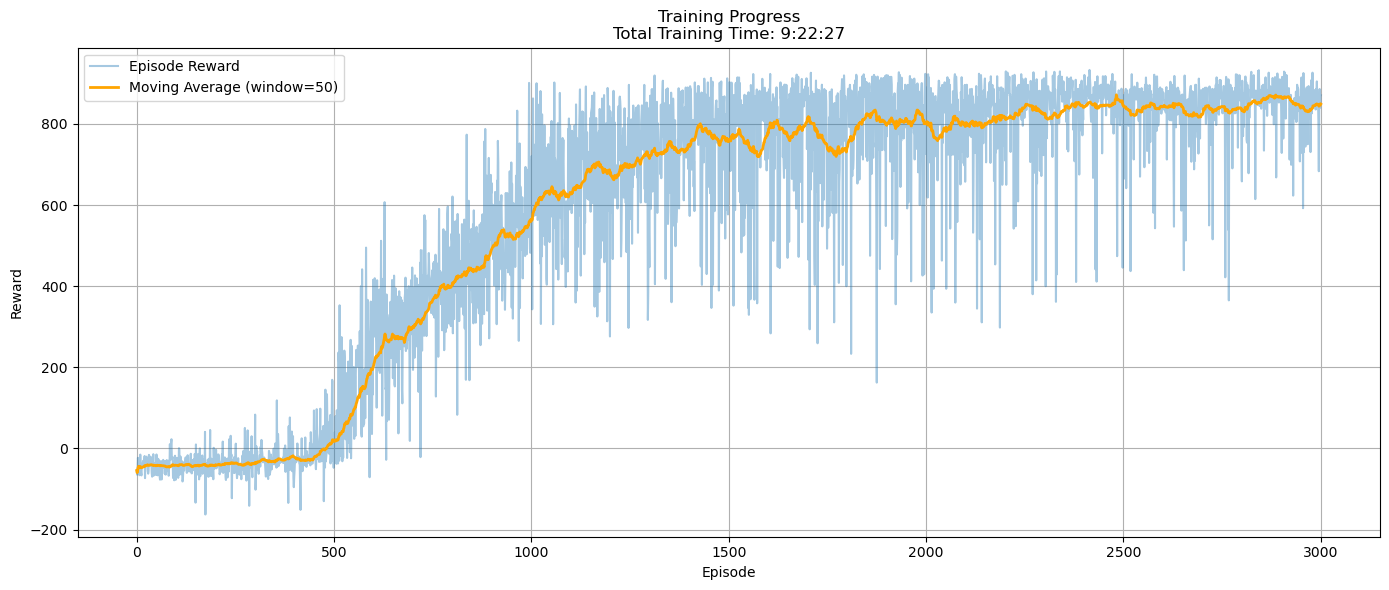

In [52]:
plot_training_progress("training/logs/DQN_log_test.csv")
plot_training_progress("training/logs/DDQN_log_test.csv")

## Run 2 episodes

In [56]:
# ====================================
# 8) CLEAN VISUAL EVALUATION FUNCTIONS
# ====================================

def setup_visual_environment(env_name="CarRacing-v3", skip_frames=4, resize_shape=84, frame_stack=4):
    """Setup environment with human rendering for visual evaluation"""
    env = gym.make(env_name, continuous=False, render_mode="human")
    env = create_skip_frame_wrapper(env, skip=skip_frames)
    env = create_grayscale_wrapper(env)
    env = create_resize_wrapper(env, shape=resize_shape)
    env = create_frame_stack_wrapper(env, num_stack=frame_stack)
    return env

def run_visual_episode(env, network, device, episode_num, max_steps=2000, sleep_time=0.01):
    """Run a single episode with visual rendering"""
    state, _ = env.reset(seed=episode_num)
    done = False
    steps = 0
    score = 0

    while not done and steps < max_steps:
        env.render()
        action = take_greedy_action(network, state, device)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        score += reward
        steps += 1
        import time
        time.sleep(sleep_time)

    return score, terminated, steps

def run_model_visually(model_name, model_path, episodes=2):
    """Run visual evaluation for a single model"""
    env = setup_visual_environment()
    state, _ = env.reset()
    action_n = env.action_space.n

    network, device = load_model_for_evaluation(model_path, state.shape, action_n)

    scores = []
    for episode in range(episodes):
        score, _, _ = run_visual_episode(env, network, device, episode_num=episode+1)
        scores.append(score)

    env.close()
    return scores


In [58]:
scores = run_model_visually("DQN", "training/saved_models/DQN_740863.pt", episodes=2)

Successfully loaded model parameters


In [57]:
scores = run_model_visually("DDQN", "training/saved_models/DDQN_743266.pt", episodes=2)

Successfully loaded model parameters
